#Constructing interpretable Neural Networks based on Domain Taxonomies

In [8]:
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/My Drive/diplom/neural-networks-fca/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install keras_tuner -q

     |████████████████████████████████| 133 kB 5.3 MB/s 


In [3]:
import pandas as pd
import numpy as np
import gc
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import tensorflow as tf
import keras
import keras_tuner
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Dropout, Input, Embedding,Reshape, Concatenate
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import SGD
from tensorflow import keras
from tensorflow.keras import layers

import os

import warnings
warnings.filterwarnings("ignore")

In this part of the research we would consider the performance of some state-of-the-art methods in terms of classification problem task with the Neural Networks based on Formal Concept Lattices.

For that propose let's take the dataset HeartDisease with binary target variable and do some investigation.


## Heart disease (dataset) 

In [21]:
import pandas as pd
import tensorflow as tf

SHUFFLE_BUFFER = 500
BATCH_SIZE = 2

csv_file = tf.keras.utils.get_file('heart.csv', 'https://storage.googleapis.com/download.tensorflow.org/data/heart.csv')
df = pd.read_csv(csv_file)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,52,1,1,118,186,0,2,190,0,0.0,2,0,fixed,0
299,43,0,4,132,341,1,2,136,1,3.0,2,0,reversible,1
300,65,1,4,135,254,0,2,127,0,2.8,2,1,reversible,1
301,48,1,4,130,256,1,2,150,1,0.0,1,2,reversible,1


In [22]:
df.to_csv(path + 'data/heart_disease.csv', index=False)

Short summary and EDA of these data:

Initial dataset:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB

Correlation with target class:
 target      1.000000
ca          0.476613
oldpeak     0.475324
cp          0.381725
exang       0.361026
slope       0.359572
age         0.198701
sex         0.171564

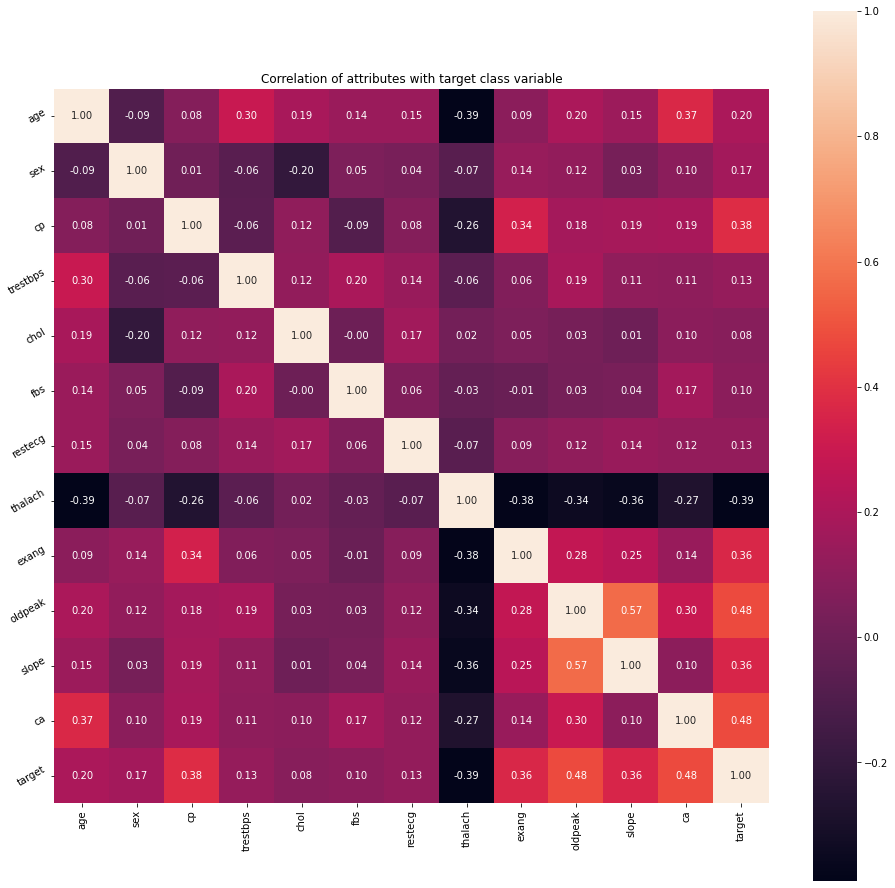

In [23]:
# data description
data = pd.read_csv(path + 'data/heart_disease.csv', sep=',')
print('Initial dataset:')
display(data.head(5))

print('\nInfo:')
data.info()

correlation = data.corr()
print('\nCorrelation with target class:\n', correlation['target'].sort_values(ascending=False))

plt.figure(figsize=(16, 16))
plt.title('\nCorrelation of attributes with target class variable')
a = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
a.set_xticklabels(a.get_xticklabels(), rotation=90)
a.set_yticklabels(a.get_yticklabels(), rotation=30)
plt.show()

In [24]:
# train, test sample to compare performance of the models

train, test = train_test_split(data, test_size=0.25, random_state=42)
train.to_csv(path + 'data/heart_disease_train.csv')
test.to_csv(path + 'data/heart_disease_test.csv')

train_ids = train.index
test_ids = test.index

In [25]:
# class balance

print('Initial dataset class balance: \n', data.target.value_counts())
print('\nTest sample class balance: \n', test.target.value_counts())

Initial dataset class balance: 
 0    220
1     83
Name: target, dtype: int64

Test sample class balance: 
 0    56
1    20
Name: target, dtype: int64


In [26]:
# check null accuracy score

null_accuracy = (220 /(83+220))
print('Null accuracy score: {0:0.4f}'. format(null_accuracy))

Null accuracy score: 0.7261


###FCA

In [ ]:
categorical = ['sex', 'cp', 'fbs', 'restecg', 'exang']

In [ ]:
features_to_be_scaled = [c for c in data.columns if len(data[c].unique()) < 10]
features_to_be_scaled.remove('target')
features_to_be_scaled

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

In [ ]:
df = pd.get_dummies(data, columns=features_to_be_scaled)
df.head()

,age,trestbps,chol,thalach,oldpeak,target,sex_0,sex_1,cp_0,cp_1,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
0,52,125,212,168,1.0,0,0,1,1,0,...,1,0,0,1,0,0,0,0,0,1
1,53,140,203,155,3.1,0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,1
2,70,145,174,125,2.6,0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,1
3,61,148,203,161,0.0,0,0,1,1,0,...,1,0,1,0,0,0,0,0,0,1
4,62,138,294,106,1.9,0,1,0,1,0,...,0,0,0,0,1,0,0,0,1,0


In [ ]:
# try inordering scaling G - a set of genes, S - set of situations, W - set of expression values (G, S, W)
temp_df = df.copy(deep=True)
numeric = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

for c in numeric:
  all_values = df[c].unique()
  for val in all_values:
    c_more = f'{c}_>={val}'
    c_less = f'{c}_<={val}'
    temp_df[c_more] = (temp_df[c] >= val)
    temp_df[c_less] = (temp_df[c] <= val)

In [ ]:
temp_df.drop(columns=['age', 'trestbps', 'chol', 'thalach', 'oldpeak'], inplace=True)
for c in temp_df.columns:
  temp_df[c] = temp_df[c].astype('bool')

X = temp_df.drop(columns=['target'], inplace=False)
y = temp_df['target']

In [ ]:
X.shape

(1025, 771)

In [ ]:
X.head()

,sex_0,sex_1,cp_0,cp_1,cp_2,cp_3,fbs_0,fbs_1,restecg_0,restecg_1,...,oldpeak_>=2.4,oldpeak_<=2.4,oldpeak_>=3.8,oldpeak_<=3.8,oldpeak_>=2.3,oldpeak_<=2.3,oldpeak_>=1.3,oldpeak_<=1.3,oldpeak_>=3.5,oldpeak_<=3.5
0,False,True,True,False,False,False,True,False,False,True,...,False,True,False,True,False,True,False,True,False,True
1,False,True,True,False,False,False,False,True,True,False,...,True,False,False,True,True,False,True,False,False,True
2,False,True,True,False,False,False,True,False,False,True,...,True,False,False,True,True,False,True,False,False,True
3,False,True,True,False,False,False,True,False,False,True,...,False,True,False,True,False,True,False,True,False,True
4,True,False,True,False,False,False,False,True,False,True,...,False,True,False,True,False,True,True,False,False,True


In [ ]:
X.to_csv('heart_bin_inordering.csv')

In [ ]:
# create FormalContext from table
from fcapy import context

K = context.FormalContext.read_csv('heart_bin_inordering.csv', sep=',')

In [ ]:
print('# objects', K.n_objects, '; # attributes', K.n_attributes)
K

# objects 1025 ; # attributes 771


FormalContext (1025 objects, 771 attributes, 395650 connections)
    |sex_0|sex_1|cp_0|cp_1|cp_2|...|oldpeak_<=2.3|oldpeak_>=1.3|oldpeak_<=1.3|oldpeak_>=3.5|oldpeak_<=3.5|
0   |     |    X|   X|    |    |...|            X|             |            X|             |            X|
1   |     |    X|   X|    |    |...|             |            X|             |             |            X|
2   |     |    X|   X|    |    |...|             |            X|             |             |            X|
3   |     |    X|   X|    |    |...|            X|             |            X|             |            X|
4   |    X|     |   X|    |    |...|            X|            X|             |             |            X|
5   |    X|     |   X|    |    |...|            X|             |            X|             |            X|
6   |     |    X|   X|    |    |...|             |            X|             |            X|             |
7   |     |    X|   X|    |    |...|            X|             |            X| 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
train_ids = X_train.index
test_ids = X_test.index

In [ ]:
X_train.to_csv('heart_bin_inordering_train.csv', sep=',')
X_test.to_csv('heart_bin_inordering_test', sep=',')

In [ ]:
K = context.FormalContext.read_csv('heart_bin_inordering_train.csv', sep=',')

In [ ]:
%%time
# create Concept Lattice
from fcapy.lattice import ConceptLattice

lat = ConceptLattice.from_context(K)
lat

## Results with state-of-the-art classification methods

In [30]:
features_to_be_scaled = [c for c in data.columns if len(data[c].unique()) < 10]
features_to_be_scaled.remove('target')
df = pd.get_dummies(data, columns=features_to_be_scaled)
std = StandardScaler()
df[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']] = std.fit_transform(df[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']])
df_train = df.iloc[train_ids]
df_test = df.iloc[test_ids]

X_train = df_train.drop(columns=['target'], inplace=False)
X_test = df_test.drop(columns=['target'], inplace=False)
y_train = df_train.target
y_test = df_test.target

In [86]:
X_train.shape, X_test.shape

((227, 31), (76, 31))

In [61]:
X_train.to_csv(path + 'data/heart_disease_X_train_standart.csv', index=False)
X_test.to_csv(path + 'data/heart_disease_X_test_standart.csv', index=False)
y_train.to_csv(path + 'data/heart_disease_y_train_standart.csv', index=False)
y_test.to_csv(path + 'data/heart_disease_y_test_standart.csv', index=False)

In [31]:
correlation_new = df.corr()
correlation_new['target'].sort_values(ascending=False)

target             1.000000
oldpeak            0.475324
cp_4               0.446411
thal_reversible    0.419345
exang_1            0.361026
slope_2            0.319264
ca_2               0.307002
ca_3               0.253979
age                0.198701
sex_1              0.171564
trestbps           0.129389
thal_fixed         0.127395
slope_3            0.123764
restecg_2          0.118581
ca_1               0.118527
fbs_1              0.097252
chol               0.083327
restecg_1          0.037322
thal_2            -0.035345
thal_1            -0.035345
cp_0              -0.071043
fbs_0             -0.097252
cp_1              -0.125344
restecg_0         -0.130488
sex_0             -0.171564
cp_2              -0.209482
cp_3              -0.231614
exang_0           -0.361026
slope_1           -0.381015
thalach           -0.386459
ca_0              -0.438111
thal_normal       -0.461859
Name: target, dtype: float64

##### XGBoost Classifier

In [32]:
# random_search to tune params for xgboost classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import RandomizedSearchCV

model_xgb = 'XGBoosting Classifier'
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}
classifier = xgb.XGBClassifier()
random_search = RandomizedSearchCV(classifier, param_distributions=params, n_iter=5, scoring='accuracy', n_jobs=-1,cv=5,verbose=3)
random_search.fit(X_train,y_train)

print("best params: \n", random_search.best_estimator_, "\n")
print(random_search.best_params_)
best_params = random_search.best_params_

classifier = xgb.XGBClassifier(
              base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=best_params['colsample_bytree'],
              gamma=best_params['gamma'], gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=best_params['max_depth'],
              min_child_weight=best_params['min_child_weight'],
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=2)

score = cross_val_score(classifier, X_train, y_train, cv=10)
score.mean()
classifier.fit(X_train, y_train)

joblib.dump(classifier, path + 'xgboost_heart_desease.pkl')

preds_xgb = classifier.predict(X_test)
accuracy_xgb = accuracy_score(y_test, preds_xgb)
print("Accuracy on testing dataset: {:.2f}% \n".format(accuracy_xgb))

f1_score_xgb = f1_score(y_test, preds_xgb)
print("F1-score on testing dataset: {:.2f}% \n".format(f1_score_xgb))

print("Classification report: \n", classification_report(y_test, preds_xgb))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
best params: 
 XGBClassifier(colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=4,
              min_child_weight=5) 

{'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.25, 'gamma': 0.0, 'colsample_bytree': 0.5}
[02:29:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[02:29:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[02:29:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[02:29:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[02:29:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[02:29:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree 

##### KNN

In [33]:
model_knn = 'K-Nearest Neighbour'
knn = KNeighborsClassifier()
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False, verbose=1)

# fitting the model for grid search
grid_search=grid.fit(X_train, y_train)
print(f"Grid search best params: {grid_search.best_params_} \n")

accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}% \n".format(accuracy))

preds_knn = grid_search.predict(X_test)
accuracy_knn = accuracy_score(y_test, preds_knn)
print("Accuracy on testing dataset: {:.2f}% \n".format(accuracy_knn))

f1_score_knn = f1_score(y_test, preds_knn)
print("F1-score on testing dataset: {:.2f}% \n".format(f1_score_knn))

print("Classification report: \n", classification_report(y_test, preds_knn))

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Grid search best params: {'n_neighbors': 7} 

Accuracy for our training dataset with tuning is : 81.96% 

Accuracy on testing dataset: 0.83% 

F1-score on testing dataset: 0.63% 

Classification report: 
               precision    recall  f1-score   support

           0       0.85      0.93      0.89        56
           1       0.73      0.55      0.63        20

    accuracy                           0.83        76
   macro avg       0.79      0.74      0.76        76
weighted avg       0.82      0.83      0.82        76



The training-set accuracy score and the test-set accuracy are quite comparable, so there is no question of overfitting.

However, to conclude that the model works well, we have to compare the results with null accuracy.  Null accuracy is the accuracy that could be achieved by always predicting the most frequent class.

In [34]:
y_test.value_counts()

0    56
1    20
Name: target, dtype: int64

In [35]:
# check null accuracy score
null_accuracy = (56 /(56+20))

print('Null accuracy score: {0:0.4f}'. format(null_accuracy))

Null accuracy score: 0.7368


We can see that the null accuracy score is 0.7368.

##### Naive Bayes

In [37]:
# Gaussian Naive Bayes
model_nb = 'Gaussian Naive Bayes'
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
preds_nb = gaussian.predict(X_test).astype(int)
accuracy = round(gaussian.score(X_train, y_train) * 100, 2)
print("Accuracy for our training dataset is : {:.2f}% \n".format(accuracy))

accuracy_nb = accuracy_score(y_test, preds_nb)
print("Accuracy on testing dataset: {:.2f}% \n".format(accuracy_nb))

f1_score_nb = f1_score(y_test, preds_nb)
print("F1-score on testing dataset: {:.2f}% \n".format(f1_score_nb))

print("Classification report: \n", classification_report(y_test, preds_nb))

Accuracy for our training dataset is : 34.80% 

Accuracy on testing dataset: 0.30% 

F1-score on testing dataset: 0.43% 

Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.05      0.10        56
           1       0.27      1.00      0.43        20

    accuracy                           0.30        76
   macro avg       0.64      0.53      0.27        76
weighted avg       0.81      0.30      0.19        76



##### Decision Tree Classifier

In [39]:
# Decision Tree Classifier
model_dt = 'Decision Tree Classifier'
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
preds_dt = decision_tree.predict(X_test).astype(int)
accuracy = round(decision_tree.score(X_train, y_train) * 100, 2)

accuracy_dt = accuracy_score(y_test, preds_dt)
print("Accuracy on testing dataset: {:.2f}% \n".format(accuracy_dt))

f1_score_dt = f1_score(y_test, preds_dt)
print("F1-score on testing dataset: {:.2f}% \n".format(f1_score_dt))

print("Classification report: \n", classification_report(y_test, preds_dt))

Accuracy on testing dataset: 0.71% 

F1-score on testing dataset: 0.48% 

Classification report: 
               precision    recall  f1-score   support

           0       0.81      0.79      0.80        56
           1       0.45      0.50      0.48        20

    accuracy                           0.71        76
   macro avg       0.63      0.64      0.64        76
weighted avg       0.72      0.71      0.71        76



##### MLP

In [41]:
train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.25)

In [42]:
valid_x.shape[1]

31

In [43]:
!pip install keras-tuner

In [44]:
import tensorflow as tf 
import keras
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Dropout, Input, Embedding, Reshape, Concatenate
from tensorflow.keras.optimizers import SGD
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from sklearn.metrics import accuracy_score

In [45]:
model_nn = 'Multilayer Perceptron'
input_dim_nn = train_x.shape[1]

def build_model(hp):
    model = keras.Sequential()
    counter = 0
    for i in range(hp.Int('num_layers', min_value=1, max_value=10)):
        if counter == 0:
            model.add(layers.Dense(hp.Int('units_' + str(i), min_value=16, max_value=256, step=16),
                                  activation='relu', kernel_initializer='he_uniform',
                                  input_dim=input_dim_nn))
            model.add(Dropout(hp.Choice('dropout' + str(i), values=[0.1, 0.2, 0.3, 0.4, 0.5])))
        else:
            model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=16, max_value=256, step=16),
                                  activation='relu', kernel_initializer='he_uniform'))
            model.add(Dropout(hp.Choice('dropout' + str(i), values=[0.1, 0.2, 0.3, 0.4, 0.5])))
        counter += 1
    model.add(layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  # case for binary classification
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [46]:
import kerastuner
tuner = RandomSearch(
    build_model,
    objective=kerastuner.Objective('accuracy', direction="max"),
    seed=42,
    max_trials=5,
    executions_per_trial=3,
    directory=path,
    project_name='kerastuner_params')

In [47]:
tuner.search(train_x, train_y, epochs=30, batch_size=256, validation_data=(valid_x, valid_y))

Trial 5 Complete [00h 00m 09s]
accuracy: 0.7980392177899679

Best accuracy So Far: 0.9686274528503418
Total elapsed time: 00h 01m 06s
INFO:tensorflow:Oracle triggered exit


In [48]:
model = tuner.get_best_models(num_models=1)[0]

In [49]:
tuner.get_best_hyperparameters()[0].values

{'dropout0': 0.3,
 'dropout1': 0.2,
 'dropout2': 0.1,
 'dropout3': 0.1,
 'dropout4': 0.4,
 'dropout5': 0.5,
 'dropout6': 0.2,
 'dropout7': 0.4,
 'dropout8': 0.5,
 'learning_rate': 0.01,
 'num_layers': 2,
 'units_0': 128,
 'units_1': 208,
 'units_2': 112,
 'units_3': 64,
 'units_4': 112,
 'units_5': 144,
 'units_6': 112,
 'units_7': 96,
 'units_8': 48}

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               4096      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 208)               26832     
                                                                 
 dropout_1 (Dropout)         (None, 208)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 209       
                                                                 
Total params: 31,137
Trainable params: 31,137
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.fit(train_x, train_y, epochs=200, initial_epoch=31, validation_data=(valid_x, valid_y))

Epoch 32/200
6/6 [==============================] - 1s 52ms/step - loss: 0.0768 - accuracy: 0.9765 - val_loss: 0.6545 - val_accuracy: 0.8070
Epoch 33/200
6/6 [==============================] - 0s 10ms/step - loss: 0.0862 - accuracy: 0.9647 - val_loss: 0.7416 - val_accuracy: 0.8421
Epoch 34/200
6/6 [==============================] - 0s 11ms/step - loss: 0.0647 - accuracy: 0.9824 - val_loss: 0.7094 - val_accuracy: 0.8070
Epoch 35/200
6/6 [==============================] - 0s 10ms/step - loss: 0.0742 - accuracy: 0.9647 - val_loss: 0.8520 - val_accuracy: 0.7544
Epoch 36/200
6/6 [==============================] - 0s 10ms/step - loss: 0.0661 - accuracy: 0.9765 - val_loss: 1.0296 - val_accuracy: 0.7895
Epoch 37/200
6/6 [==============================] - 0s 11ms/step - loss: 0.0492 - accuracy: 0.9824 - val_loss: 1.2962 - val_accuracy: 0.7895
Epoch 38/200
6/6 [==============================] - 0s 11ms/step - loss: 0.1102 - accuracy: 0.9412 - val_loss: 1.1212 - val_accuracy: 0.7719
Epoch 39/200


In [53]:
preds_nn = model.predict(X_test)

In [54]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 5ms/step - loss: 2.4067 - accuracy: 0.8289


[2.4066641330718994, 0.8289473652839661]

In [55]:
preds_nn[preds_nn <= 0.5] = 0
preds_nn[preds_nn > 0.5] = 1

In [56]:
y_test

179    0
228    1
111    0
246    0
60     0
      ..
22     0
258    0
56     0
242    0
114    0
Name: target, Length: 76, dtype: int64

In [57]:
accuracy_nn = accuracy_score(y_test, preds_nn)
print("Accuracy on testing dataset: {:.2f}% \n".format(accuracy_nn))

f1_score_nn = f1_score(y_test, preds_nn)
print("F1-score on testing dataset: {:.2f}% \n".format(f1_score_nn))

print("Classification report: \n", classification_report(y_test, preds_nn))

Accuracy on testing dataset: 0.83% 

F1-score on testing dataset: 0.67% 

Classification report: 
               precision    recall  f1-score   support

           0       0.88      0.89      0.88        56
           1       0.68      0.65      0.67        20

    accuracy                           0.83        76
   macro avg       0.78      0.77      0.78        76
weighted avg       0.83      0.83      0.83        76



##### Random Forest

In [59]:
# Random Forest
model_rf = 'Random Forest'
random_forest = GridSearchCV(estimator=RandomForestClassifier(), param_grid={'n_estimators': [200, 300, 400, 500]}, cv=5).fit(X_train, y_train)
random_forest.fit(X_train, y_train)
preds_rf = random_forest.predict(X_test).astype(int)

accuracy_rf = accuracy_score(y_test, preds_rf)
print("Accuracy on testing dataset: {:.2f}% \n".format(accuracy_rf))

f1_score_rf = f1_score(y_test, preds_rf)
print("F1-score on testing dataset: {:.2f}% \n".format(f1_score_rf))

print("Classification report: \n", classification_report(y_test, preds_rf))

Accuracy on testing dataset: 0.82% 

F1-score on testing dataset: 0.61% 

Classification report: 
               precision    recall  f1-score   support

           0       0.85      0.91      0.88        56
           1       0.69      0.55      0.61        20

    accuracy                           0.82        76
   macro avg       0.77      0.73      0.75        76
weighted avg       0.81      0.82      0.81        76



So, we can make a summary:

In [75]:
# for binary classification

data_path = path + 'data/'
models_path = path + 'data/models_files'

class BaseClassifiers:
    def __init__(self, x_train, x_test, y_train, y_test, dataset_name=''):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        self.dataset_name = dataset_name

    def kNeighboursClassifier(self):
        """
        :return: accuracy, f1_score, classification_report by kNN classifier on x_test dataset
        """
        knn = KNeighborsClassifier()
        k_range = list(range(1, 31))
        param_grid = dict(n_neighbors=k_range)

        # defining parameter range
        grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False, verbose=1)

        # fitting the model for grid search
        grid_search = grid.fit(self.x_train, self.y_train)
        preds_knn = grid_search.predict(self.x_test)

        res_knn = self._evaluate_model(preds_knn)
        return res_knn

    def naiveBayes(self):
        """
        :return: accuracy, f1_score, classification_report by Gaussian Naive Bayes on x_test dataset
        """
        gaussian = GaussianNB()
        gaussian.fit(self.x_train, self.y_train)
        preds_nb = gaussian.predict(self.x_test).astype(int)
        # accuracy on training data
        accuracy = round(gaussian.score(self.x_train, self.y_train) * 100, 2)

        res_nb = self._evaluate_model(preds_nb)
        return res_nb

    def decisionTree(self):
        """
        :return: accuracy, f1_score by Decision Tree Classifier on x_test dataset
        """
        decision_tree = DecisionTreeClassifier()
        decision_tree.fit(self.x_train, self.y_train)
        preds_dt = decision_tree.predict(self.x_test).astype(int)
        # accuracy on training data
        accuracy = round(decision_tree.score(self.x_train, self.y_train) * 100, 2)

        res_dt = self._evaluate_model(preds_dt)
        return res_dt

    def randomForest(self):
        """
        :return: accuracy, f1_score, classification_report by RandomForest classifier on x_test dataset
        """
        rf = RandomForestClassifier(n_estimators=20, random_state=12, max_depth=10)
        rf.fit(self.x_train, self.y_train)
        preds_rf = rf.predict(self.x_test)

        res_rf = self._evaluate_model(preds_rf)
        return res_rf

    def xgbclassifier(self):
        """
        :return: results on testing dataset by tuned XGBoost classifier
        """
        params = {
            "learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
            "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
            "min_child_weight": [1, 3, 5, 7],
            "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
            "colsample_bytree": [0.3, 0.4, 0.5, 0.7]
        }
        classifier = xgb.XGBClassifier()
        random_search = RandomizedSearchCV(classifier, param_distributions=params, n_iter=5,
                                           scoring='accuracy', n_jobs=-1, cv=10, verbose=3)
        random_search.fit(self.x_train, self.y_train)
        best_params = random_search.best_params_

        classifier = xgb.XGBClassifier(
            base_score=0.5, booster='gbtree', colsample_bylevel=1,
            colsample_bynode=1, colsample_bytree=best_params['colsample_bytree'],
            gamma=best_params['gamma'], gpu_id=0,
            importance_type='gain', interaction_constraints='',
            learning_rate=0.1, max_delta_step=0, max_depth=best_params['max_depth'],
            min_child_weight=best_params['min_child_weight'],
            n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
            reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
            tree_method='exact', validate_parameters=1, verbosity=2)

        score = cross_val_score(classifier, self.x_train, self.y_train, cv=10)
        score.mean()
        classifier.fit(self.x_train, self.y_train)
        joblib.dump(classifier, models_path + f'/xgboost_{self.dataset_name}.pkl')
        preds_xgb = classifier.predict(self.x_test)

        res_xgb = self._evaluate_model(preds_xgb)
        return res_xgb

    def mlp(self):
        """
        :return: results on testing dataset by tuned Multilayer Perceptron
        """
        # for binary classification
        train_x, valid_x, train_y, valid_y = train_test_split(self.x_train, self.y_train, test_size=0.2)
        input_dim_nn = train_x.shape[1]
        def build_model(hp):
            model = keras.Sequential()
            counter = 0
            for i in range(hp.Int('num_layers', min_value=1, max_value=10)):
                if counter == 0:
                    model.add(layers.Dense(hp.Int('units_' + str(i), min_value=16, max_value=256, step=16),
                                           activation='relu', kernel_initializer='he_uniform',
                                           input_dim=input_dim_nn))
                    model.add(Dropout(hp.Choice('dropout' + str(i), values=[0.1, 0.2, 0.3, 0.4, 0.5])))
                else:
                    model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=16, max_value=256, step=16),
                                           activation='relu', kernel_initializer='he_uniform'))
                    model.add(Dropout(hp.Choice('dropout' + str(i), values=[0.1, 0.2, 0.3, 0.4, 0.5])))
                counter += 1
            model.add(layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform'))
            model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                          # case for binary classification
                          loss='binary_crossentropy',
                          metrics=['accuracy'])
            return model

        tuner = RandomSearch(
            build_model,
            objective=kerastuner.Objective('accuracy', direction="max"),
            seed=42,
            max_trials=5,
            executions_per_trial=3,
            directory=models_path,
            project_name='kerastuner_params')

        tuner.search(train_x, train_y, epochs=30, batch_size=256, validation_data=(valid_x, valid_y))
        model = tuner.get_best_models(num_models=1)[0]
        model.fit(train_x, train_y, epochs=200, initial_epoch=31, validation_data=(valid_x, valid_y))

        gc.collect()

        print(model.summary())
        model.evaluate(self.x_test, self.y_test)
        preds_mlp = model.predict(self.x_test)
        preds_mlp[preds_mlp <= 0.5] = 0
        preds_mlp[preds_mlp > 0.5] = 1

        res_mlp = self._evaluate_model(preds_mlp)
        return res_mlp

    def _evaluate_model(self, preds):
        """
        :param preds: predictions by classifier
        :return: accuracy, f1_score and the values of true positive
                 and false negative rate
        """
        acc = accuracy_score(self.y_test, preds)
        f1 = f1_score(self.y_test, preds)
        report = classification_report(self.y_test, preds)
        print('Classification report on testing sample: \n', report)
        # for binary classification
        roc_auc = roc_auc_score(self.y_test, preds)

        # for the case when we have binary classification
        fpr, tpr, _ = roc_curve(self.y_test, preds)
        return acc, f1, roc_auc, fpr, tpr

    def compare_models(self) -> pd.DataFrame:
        """
        Compares the perfomance of the state-of-the-art models on the testing data
        :return: pd.DataFrame
        """
        models = ['K-Nearest Neighbours', 'Gaussian Naive Bayes', 'Decision Tree Classifier',
                  'Random Forest', 'XGBoost Classifier', 'Multilayer Perceptron (NN)']
        data = [self.kNeighboursClassifier(),
                self.naiveBayes(),
                self.decisionTree(),
                self.randomForest(),
                self.xgbclassifier(),
                self.mlp()]
        models_df = pd.DataFrame(data, columns=['accuracy', 'f1_score', 'roc_auc', 'fpr', 'tpr'])
        models_df['Model'] = models
        models_df.sort_values(by='accuracy', ascending=False, inplace=True)
        models_df.to_csv(data_path + f'/{self.dataset_name}_res.csv')
        print(models_df)
        return models_df

    @staticmethod
    def plot_roc_auc(df: pd.DataFrame):
        pass

In [76]:
clf_heart_disease = BaseClassifiers(X_train, X_test, y_train, y_test, 'Heart Disease')
res_heart_disease = clf_heart_disease.compare_models()

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Classification report on testing sample: 
               precision    recall  f1-score   support

           0       0.85      0.93      0.89        56
           1       0.73      0.55      0.63        20

    accuracy                           0.83        76
   macro avg       0.79      0.74      0.76        76
weighted avg       0.82      0.83      0.82        76

Classification report on testing sample: 
               precision    recall  f1-score   support

           0       1.00      0.05      0.10        56
           1       0.27      1.00      0.43        20

    accuracy                           0.30        76
   macro avg       0.64      0.53      0.27        76
weighted avg       0.81      0.30      0.19        76

Classification report on testing sample: 
               precision    recall  f1-score   support

           0       0.82      0.80      0.81        56
           1       0.48      0.50      0.49  

In [77]:
res_heart_disease

,accuracy,f1_score,roc_auc,fpr,tpr,Model
4,0.842105,0.700000,0.796429,"[0.0, 0.10714285714285714, 1.0]","[0.0, 0.7, 1.0]",XGBoost Classifier
0,0.828947,0.628571,0.739286,"[0.0, 0.07142857142857142, 1.0]","[0.0, 0.55, 1.0]",K-Nearest Neighbours
3,0.815789,0.650000,0.762500,"[0.0, 0.125, 1.0]","[0.0, 0.65, 1.0]",Random Forest
5,0.789474,0.600000,0.728571,"[0.0, 0.14285714285714285, 1.0]","[0.0, 0.6, 1.0]",Multilayer Perceptron (NN)
2,0.723684,0.487805,0.651786,"[0.0, 0.19642857142857142, 1.0]","[0.0, 0.5, 1.0]",Decision Tree Classifier
1,0.302632,0.430108,0.526786,"[0.0, 0.9464285714285714, 1.0]","[0.0, 1.0, 1.0]",Gaussian Naive Bayes


In [82]:
heart_disease_clf_res = res_heart_disease.drop(columns=['fpr', 'tpr'])
heart_disease_clf_res.set_index('Model', inplace=True)
heart_disease_clf_res

,accuracy,f1_score,roc_auc
Model,,,
XGBoost Classifier,0.842105,0.700000,0.796429
K-Nearest Neighbours,0.828947,0.628571,0.739286
Random Forest,0.815789,0.650000,0.762500
Multilayer Perceptron (NN),0.789474,0.600000,0.728571
Decision Tree Classifier,0.723684,0.487805,0.651786
Gaussian Naive Bayes,0.302632,0.430108,0.526786


In [83]:
heart_disease_clf_res.to_csv(data_path + 'results_heart_disease_main.csv', index=False)

Now let's try other datasets:

In [6]:
data = pd.read_csv(path + 'data/tic-tac-toe.csv')

In [7]:
data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive
...,...,...,...,...,...,...,...,...,...,...
953,o,x,x,x,o,o,o,x,x,negative
954,o,x,o,x,x,o,x,o,x,negative
955,o,x,o,x,o,x,x,o,x,negative
956,o,x,o,o,x,x,x,o,x,negative


In [ ]:
def preprocessing(data: pd.DataFrame):
  data['V10'].replace()
  data = pd.get_dummies(data, columns=)
